In [1]:
import pandas as pd
import numpy as np
import urllib2
import csv
import pylab as pl
import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# download city population estimate into database 
# from here: https://www.census.gov/popest/data/metro/totals/2014/index.html
# cut off at 100,000 population
df = pd.read_csv('100cities.csv')

# clean up data
df['Geography'] = df['Geography'].map(lambda x: x.replace('Metro Area',''))
df['Geography'] = df['Geography'].map(lambda x: x.replace('Micro Area',''))
df['Geography'] = df['Geography'].map(lambda x: x.replace('Metro Division', ''))
df['Geography'] = df['Geography'].map(lambda x: x.rstrip())
df['Geography'] = df['Geography'].map(lambda x: x.lstrip())
df['CBSA Title'] = df['Geography']
del df['Geography']

In [3]:
# download list of counties per CSA (caveat that csa's are derived with 2013 population estimates)
df2 = pd.read_csv('CensusCSA.csv', header = 2, usecols = ['CBSA Title', 
                                                          'CSA Code', 
                                                          'Metropolitan/Micropolitan Statistical Area', 
                                                          'CSA Title', "County/County Equivalent", 
                                                          'State Name', "FIPS County Code", 
                                                          "Central/Outlying County"])

In [4]:
# merge the datasets
city_counties = pd.merge(df2, df, on='CBSA Title')
# remove puerto rico
city_counties = city_counties[city_counties['State Name'] != 'Puerto Rico']

In [5]:
# download 2002 popution for all counties all states
state_pop = pd.read_csv('county_pop2002.csv')

In [6]:
# download updated city_county with concatenated state+county FIPS
county_pop = pd.read_csv('csa_counties.csv')

In [7]:
# merge the top cities' counties with the 2002 population data
city_county_pop = pd.merge(county_pop, state_pop, on = 'STCOU')
city_county_pop['FIPS'] = city_county_pop['STCOU']

In [8]:
# download the Vulcan energy data
energy = pd.read_csv('county_sector.csv', 
                     usecols=['State',' County', 
                              ' FIPS', ' Total', 'Commercial', 
                              'Industrial','Residential',
                              'Electricity Prod','Onroad', 
                              'Cement','Aircraft','Nonroad','Airborne'])

energy['FIPS'] = energy[' FIPS']

In [9]:
#merge census data with the energy data
city_energy = pd.merge(energy, city_county_pop, on = 'FIPS')

In [10]:
# download county area data
county_area = pd.read_csv('county_area.csv', usecols = ['USPS', 'FIPS', 'NAME', 'ALAND','ALAND_SQMI'])

# Start here to re-create 'df_master'

In [11]:
# merge to create master file
df_master = pd.merge(city_energy, county_area, on = 'FIPS')

In [12]:
# clean and rename columns
del df_master[' County']
del df_master[' FIPS']
del df_master['Areaname']
del df_master['USPS']
del df_master['STCOU']
del df_master['county_state']
del df_master['State Code']
del df_master['State Name']
del df_master['County/County Equivalent']
del df_master['FIPS County Code']
del df_master['ALAND']
df_master = df_master.rename(columns = {'State': 'state', ' Total': 'tot_co2',
                    'Metropolitan/Micropolitan Statistical Area': 'MSAMCA',
                    'Central/Outlying County': 'center-outer', '2014 estimate': 'city_pop2014',
                    'PST045202D': 'county_pop2002', 'NAME': 'county',
                    'ALAND_SQMI': 'county_land_area_sqmi', 'Geography': 'CBSA'})

In [13]:
# re-scale emission units to tons from millions of tons
# more column clean up
df_master['tot_co2'] = df_master['tot_co2']*1000000
df_master['Commercial'] = df_master['Commercial']*1000000
df_master['Industrial'] = df_master['Industrial']*1000000
df_master['Residential'] = df_master['Residential']*1000000
df_master['Electricity Prod'] = df_master['Electricity Prod']*1000000
df_master['Onroad'] = df_master['Onroad']*1000000
df_master['Cement'] = df_master['Cement']*1000000
df_master['Aircraft'] = df_master['Aircraft']*1000000
df_master['Airborne'] = df_master['Airborne']*1000000
df_master['Nonroad'] = df_master['Nonroad']*1000000

In [14]:
# conversions to top level city designation: CSA or CBSA
df_master['convert'] = df_master['CSA Title'].apply(lambda x: str(x))
df_master.ix[df_master['convert'] != 'nan', 'PSA'] = df_master['CSA Title']
df_master.ix[df_master['convert'] == 'nan', 'PSA'] = df_master['CBSA Title']
df_master.ix[df_master['convert'] != 'nan', 'CSA'] = True
df_master.ix[df_master['convert'] == 'nan', 'CSA'] = False
del df_master['convert']
del df_master['CSA Title']

##County

In [15]:
# county density
df_master['county_d'] = df_master['county_pop2002']*1.0/df_master['county_land_area_sqmi']

# county per capita
df_master['co2_pc'] = df_master['county_pop2002']*1.0/df_master['tot_co2']

# county per capita electric
df_master['county_elec_pc'] = df_master['Electricity Prod']*1.0/df_master['county_pop2002']

##Central vs Outlying

In [16]:
# create central and outlying datasets
dfc = df_master[df_master['center-outer'] == "Central"]
dfo = df_master[df_master['center-outer'] == 'Outlying']
print len(dfc), len(dfo)

744 452


##PSA (CSA + CBSA)

In [17]:
# csa city pop
csa_p = df_master['county_pop2002'].groupby(df_master['PSA']).sum()
csa_a = df_master['county_land_area_sqmi'].groupby(df_master['PSA']).sum()
csa_d = csa_p*1.0/csa_a

# csa city emissions
csa_co2 = df_master['tot_co2'].groupby(df_master['PSA']).sum()
csa_pc = csa_co2*1.0/csa_p

#csa electricity
csa_elec = df_master['Electricity Prod'].groupby(df_master['PSA']).sum()
csa_elec_pc = csa_elec*1.0/csa_p

# Descriptive Stats

In [18]:
csa_pc.describe()

count    271.000000
mean       6.460664
std        7.194530
min        1.623466
25%        3.142061
50%        4.147853
75%        6.468026
max       71.474772
dtype: float64

##CBSA

In [19]:
# cbsa city pop
cbsa_p = df_master['county_pop2002'].groupby(df_master['CBSA']).sum()
cbsa_a = df_master['county_land_area_sqmi'].groupby(df_master['CBSA']).sum()
cbsa_d = cbsa_p*1.0/cbsa_a

# cbsa city emissions
cbsa_co2 = df_master['tot_co2'].groupby(df_master['CBSA']).sum()
cbsa_pc = cbsa_co2*1.0/cbsa_p

# cbsa electricity
cbsa_elec = df_master['Electricity Prod'].groupby(df_master['CBSA']).sum()
cbsa_elec_pc = cbsa_elec*1.0/cbsa_p

#**CBSA

In [20]:
# set x and y
ind_var = cbsa_d
dep_var = cbsa_pc

xy = pd.concat([ind_var, dep_var], axis=1)
xy = xy.rename(columns = {0: 'ind_var', 1: 'dep_var'})

# remove outliers -z3 < cut > z3
#xthreshold = xy.ind_var.mean()+xy.ind_var.std()*3,xy.ind_var.mean()-xy.ind_var.std()*3
#ythreshold = xy.dep_var.mean()+xy.dep_var.std()*3, xy.dep_var.mean()-xy.dep_var.std()*3
#xy_cut = xy[(xy.ind_var < xthreshold[0]) & (xy.ind_var > xthreshold[1])]
#xy_cut = xy_cut[(xy_cut.dep_var < ythreshold[0]) & (xy_cut.dep_var > ythreshold[1])]

xy_cut = xy
# log10
xy_cut['xlog'] = np.log10(xy_cut.ind_var)
xy_cut['ylog'] = np.log10(xy_cut.dep_var)

#Linear or polynomial regression CBSA

In [21]:
# 1 degree line regression = least squares

X = sm.add_constant(xy_cut.xlog)
fit1 = sm.OLS(xy_cut.ylog, X, missing='drop').fit()

print "Log-likelihood for 1 degree fit of least squares is: {}".format(fit1.llf)

# 2 degree line regression
curve = smf.ols(formula = "y ~ x1 + I(x1) + I((x1**2))", 
        data={'x1':xy_cut.xlog,'y': xy_cut.ylog}).fit()

print "Log-likelihood for 2 degree fit of least squares is: {}".format(curve.llf)
# determine better model with loglikelihood ratio
lrt = -2*(fit1.llf - curve.llf)
print '\n'
if lrt > 3.84:
    print 'CURVE is best fit: {} is > 3.84\n'.format(lrt)
    print curve.summary()
else:
    print '1DEG is best fit: {} is < 3.84\n'.format(lrt)
    print fit1.summary()

Log-likelihood for 1 degree fit of least squares is: -49.5517496128
Log-likelihood for 2 degree fit of least squares is: -49.2725764674


1DEG is best fit: 0.558346290826 is < 3.84

                            OLS Regression Results                            
Dep. Variable:                   ylog   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     13.12
Date:                Fri, 20 Nov 2015   Prob (F-statistic):           0.000332
Time:                        05:23:40   Log-Likelihood:                -49.552
No. Observations:                 379   AIC:                             103.1
Df Residuals:                     377   BIC:                             111.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std

#PLOT CBSA

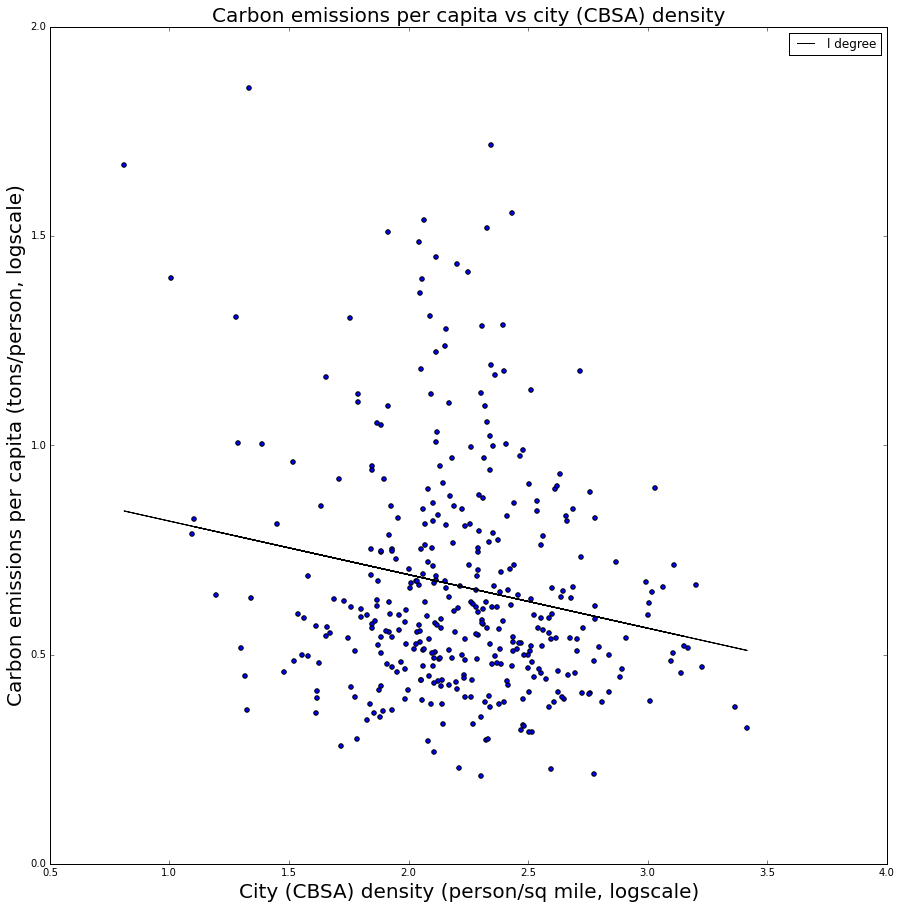

In [22]:
fig = pl.figure(figsize=(15,15))
xy_cut.plot(kind = 'scatter', x = 'xlog', y = 'ylog', figsize = (15,15))
plot(xy_cut.xlog, fit1.predict(), 'k', label="l degree")
#plot(xy_cut.xlog, curve.predict(), 'ro', label="2 degree")
pl.title("Carbon emissions per capita vs city (CBSA) density", fontsize = 20)
pl.xlabel("City (CBSA) density (person/sq mile, logscale)", fontsize=20)
pl.ylabel("Carbon emissions per capita (tons/person, logscale)", fontsize=20)
pl.legend()

# CBSA Supplementary Pearson correlation

In [23]:
# conducting Pearson's test
pearson = scipy.stats.pearsonr(xy_cut.xlog, xy_cut.ylog)
pearson_alpha = 0.05

r,p = pearson
def pearson_results(r,p,a):
    print("The Pearson r coefficient is {}. Is the 2-tailed p-value of {} smaller than {}?".format(r,p,a))
    if p<a:
        print ("Yes.")
    else:
        print ("Nope.")
    
    print ('The correlation is {} at the {} alpha level.'.format(('significant' if p<a  else 'not significant'),a)) 

pearson_results(r,p,pearson_alpha)

The Pearson r coefficient is -0.183395437944. Is the 2-tailed p-value of 0.000331921904215 smaller than 0.05?
Yes.
The correlation is significant at the 0.05 alpha level.


#**PSA

In [24]:
# set x and y
ind_var2 = csa_d
dep_var2 = csa_pc

xy2 = pd.concat([ind_var2, dep_var2], axis=1)
xy2 = xy2.rename(columns = {0: 'ind_var', 1: 'dep_var'})

# remove outliers -z3 < cut > z3
#xthreshold2 = xy2.ind_var.mean()+xy2.ind_var.std()*3,xy2.ind_var.mean()-xy2.ind_var.std()*3
#ythreshold2 = xy2.dep_var.mean()+xy2.dep_var.std()*3, xy2.dep_var.mean()-xy2.dep_var.std()*3
#xy_cut2 = xy2[(xy2.ind_var < xthreshold2[0]) & (xy2.ind_var > xthreshold2[1])]
#xy_cut2 = xy_cut2[(xy_cut2.dep_var < ythreshold2[0]) & (xy_cut2.dep_var > ythreshold2[1])]

# log10
xy_cut2 = xy2
xy_cut2['xlog'] = np.log10(xy_cut2.ind_var)
xy_cut2['ylog'] = np.log10(xy_cut2.dep_var)

#Linear or polynomial regression PSA

In [25]:
# 1 degree line regression = least squares

X2 = sm.add_constant(xy_cut2.xlog)
fit12 = sm.OLS(xy_cut2.ylog, X2, missing='drop').fit()

print "Log-likelihood for 1 degree fit of least squares is: {}".format(fit12.llf)

# 2 degree line regression
curve2 = smf.ols(formula = "y ~ x1 + I(x1) + I((x1**2))", 
        data={'x1':xy_cut2.xlog,'y': xy_cut2.ylog}).fit()

print "Log-likelihood for 2 degree fit of least squares is: {}".format(curve2.llf)
# determine better model with loglikelihood ratio
lrt2 = -2*(fit12.llf - curve2.llf)
print '\n'
if lrt2 > 3.84:
    print 'CURVE is best fit: {} is > 3.84\n'.format(lrt2)
    print curve2.summary()
else:
    print '1DEG is best fit: {} is < 3.84\n'.format(lrt2)
    print fit12.summary()

Log-likelihood for 1 degree fit of least squares is: -35.2553470198
Log-likelihood for 2 degree fit of least squares is: -34.7068406229


1DEG is best fit: 1.09701279382 is < 3.84

                            OLS Regression Results                            
Dep. Variable:                   ylog   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     6.768
Date:                Fri, 20 Nov 2015   Prob (F-statistic):            0.00980
Time:                        05:23:45   Log-Likelihood:                -35.255
No. Observations:                 271   AIC:                             74.51
Df Residuals:                     269   BIC:                             81.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std 

#PLOT PSA

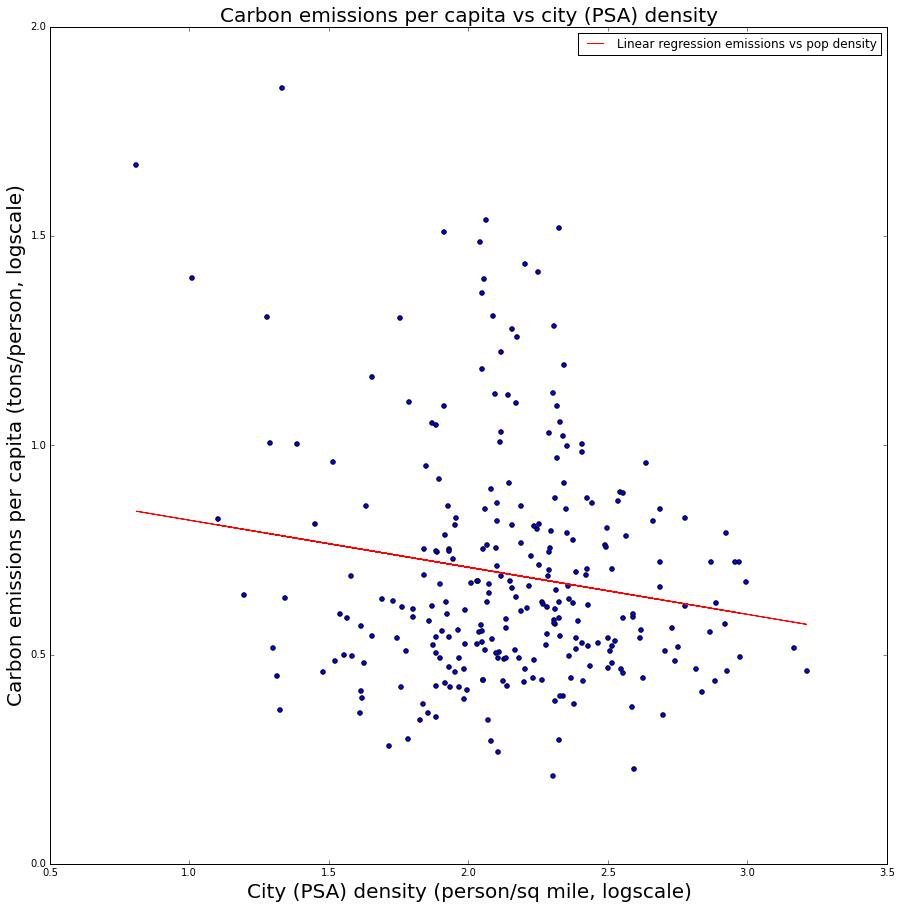

In [26]:
fig = pl.figure(figsize=(15,15))
xy_cut2.plot(kind = 'scatter', x = 'xlog', y = 'ylog', figsize = (15,15))
plot(xy_cut2.xlog, fit12.predict(), 'r', label="Linear regression emissions vs pop density")
#plot(xy_cut2.xlog, curve2.predict(), 'ro', label="2 degree")
pl.title("Carbon emissions per capita vs city (PSA) density", fontsize = 20)
pl.xlabel("City (PSA) density (person/sq mile, logscale)", fontsize=20)
pl.ylabel("Carbon emissions per capita (tons/person, logscale)", fontsize=20)
pl.legend()
pl.show()

# PSA Pearson

In [27]:
# conducting Pearson's test
pearson2 = scipy.stats.pearsonr(xy_cut2.xlog, xy_cut2.ylog)
pearson_alpha = 0.05

r,p = pearson2
def pearson_results2(r,p,a):
    print("The Pearson r coefficient is {}. Is the 2-tailed p-value of {} smaller than {}?".format(r,p,a))
    if p<a:
        print ("Yes.")
    else:
        print ("Nope.")
    
    print ('The correlation is {} at the {} alpha level.'.format(('significant' if p<a  else 'not significant'),a)) 

pearson_results2(r,p,pearson_alpha)

The Pearson r coefficient is -0.156657581574. Is the 2-tailed p-value of 0.00979578255677 smaller than 0.05?
Yes.
The correlation is significant at the 0.05 alpha level.


#**CBSA-POP

In [28]:
# set x and y
ind_var3 = cbsa_p
dep_var3 = cbsa_pc

xy3 = pd.concat([ind_var3, dep_var3], axis=1)
xy3 = xy3.rename(columns = {0: 'ind_var', 1: 'dep_var'})

# remove outliers -z3 < cut > z3
#xthreshold3 = xy3.ind_var.mean()+xy3.ind_var.std()*3,xy3.ind_var.mean()-xy3.ind_var.std()*3
#ythreshold3 = xy3.dep_var.mean()+xy3.dep_var.std()*3, xy3.dep_var.mean()-xy3.dep_var.std()*3
#xy_cut3 = xy3[(xy3.ind_var < xthreshold3[0]) & (xy3.ind_var > xthreshold3[1])]
#xy_cut3 = xy_cut3[(xy_cut3.dep_var < ythreshold3[0]) & (xy_cut3.dep_var > ythreshold3[1])]

# log10
xy_cut3 = xy3
xy_cut3['xlog'] = np.log10(xy_cut3.ind_var)
xy_cut3['ylog'] = np.log10(xy_cut3.dep_var)

#CBSA Linear Regression - POP

In [29]:
# 1 degree line regression = least squares

X3 = sm.add_constant(xy_cut3.xlog)
fit13 = sm.OLS(xy_cut3.ylog, X3, missing='drop').fit()

print "Log-likelihood for 1 degree fit of least squares is: {}".format(fit13.llf)

# 2 degree line regression
curve3 = smf.ols(formula = "y ~ x1 + I(x1) + I((x1**2))", 
        data={'x1':xy_cut3.xlog,'y': xy_cut3.ylog}).fit()

print "Log-likelihood for 2 degree fit of least squares is: {}".format(curve3.llf)
# determine better model with loglikelihood ratio
lrt3 = -2*(fit13.llf - curve3.llf)
print '\n'
if lrt3 > 3.84:
    print 'CURVE is best fit: {} is > 3.84\n'.format(lrt3)
    print curve3.summary()
else:
    print '1DEG is best fit: {} is < 3.84\n'.format(lrt3)
    print fit13.summary()

Log-likelihood for 1 degree fit of least squares is: -54.2934683224
Log-likelihood for 2 degree fit of least squares is: -53.7261958985


1DEG is best fit: 1.1345448478 is < 3.84

                            OLS Regression Results                            
Dep. Variable:                   ylog   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.481
Date:                Fri, 20 Nov 2015   Prob (F-statistic):             0.0629
Time:                        05:23:51   Log-Likelihood:                -54.293
No. Observations:                 379   AIC:                             112.6
Df Residuals:                     377   BIC:                             120.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std e

#PLOT CBSA POP

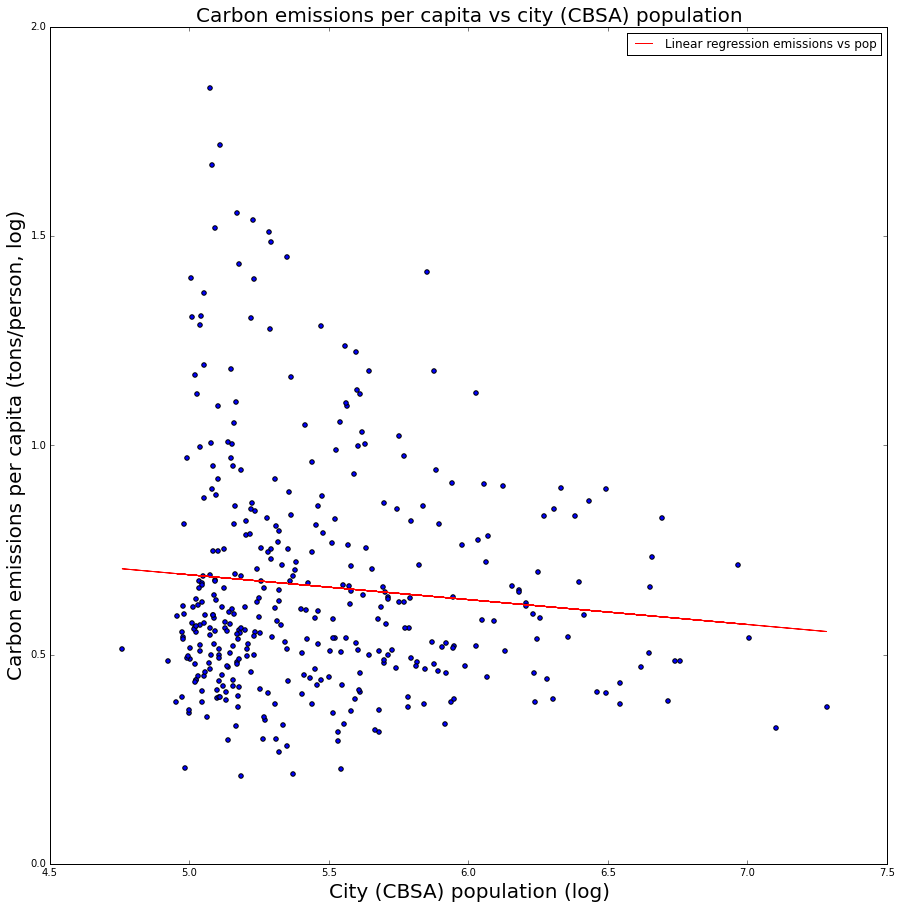

In [30]:
fig = pl.figure(figsize=(15,15))
xy_cut3.plot(kind = 'scatter', x = 'xlog', y = 'ylog', figsize = (15,15))
plot(xy_cut3.xlog, fit13.predict(), 'r', label="Linear regression emissions vs pop")
#plot(xy_cut3.xlog, curve3.predict(), 'ro', label="2 degree")
pl.title("Carbon emissions per capita vs city (CBSA) population", fontsize = 20)
pl.xlabel("City (CBSA) population (log)", fontsize=20)
pl.ylabel("Carbon emissions per capita (tons/person, log)", fontsize=20)
pl.legend()

# CBSA POP Pearson

In [31]:
# conducting Pearson's test
pearson3 = scipy.stats.pearsonr(xy_cut3.xlog, xy_cut3.ylog)
pearson_alpha = 0.05

r,p = pearson3
def pearson_results3(r,p,a):
    print("The Pearson r coefficient is {}. Is the 2-tailed p-value of {} smaller than {}?".format(r,p,a))
    if p<a:
        print ("Yes.")
    else:
        print ("Nope.")
    
    print ('The correlation is {} at the {} alpha level.'.format(('significant' if p<a  else 'not significant'),a)) 

pearson_results3(r,p,pearson_alpha)

The Pearson r coefficient is -0.0956459806452. Is the 2-tailed p-value of 0.0628650850365 smaller than 0.05?
Nope.
The correlation is not significant at the 0.05 alpha level.


#**PSA POP

In [32]:
# set x and y
ind_var4 = csa_p
dep_var4 = csa_pc

xy4 = pd.concat([ind_var4, dep_var4], axis=1)
xy4 = xy4.rename(columns = {0: 'ind_var', 1: 'dep_var'})

# remove outliers -z3 < cut > z3
#xthreshold4 = xy4.ind_var.mean()+xy4.ind_var.std()*3,xy4.ind_var.mean()-xy4.ind_var.std()*3
#ythreshold4 = xy4.dep_var.mean()+xy4.dep_var.std()*3, xy4.dep_var.mean()-xy4.dep_var.std()*3
#xy_cut4 = xy4[(xy4.ind_var < xthreshold4[0]) & (xy4.ind_var > xthreshold4[1])]
#xy_cut4 = xy_cut4[(xy_cut4.dep_var < ythreshold4[0]) & (xy_cut4.dep_var > ythreshold4[1])]

# log10
xy_cut4 = xy4
xy_cut4['xlog'] = np.log10(xy_cut4.ind_var)
xy_cut4['ylog'] = np.log10(xy_cut4.dep_var)

#PSA Linear Regression POP

In [33]:
# 1 degree line regression = least squares

X4 = sm.add_constant(xy_cut4.xlog)
fit14 = sm.OLS(xy_cut4.ylog, X4, missing='drop').fit()

print "Log-likelihood for 1 degree fit of least squares is: {}".format(fit14.llf)

# 2 degree line regression
curve4 = smf.ols(formula = "y ~ x1 + I(x1) + I((x1**2))", 
        data={'x1':xy_cut4.xlog,'y': xy_cut4.ylog}).fit()

print "Log-likelihood for 2 degree fit of least squares is: {}".format(curve4.llf)
# determine better model with loglikelihood ratio
lrt4 = -2*(fit14.llf - curve4.llf)
print '\n'
if lrt4 > 3.84:
    print 'CURVE is best fit: {} is > 3.84\n'.format(lrt4)
    print curve4.summary()
else:
    print '1DEG is best fit: {} is < 3.84\n'.format(lrt4)
    print fit14.summary()

Log-likelihood for 1 degree fit of least squares is: -36.4032610649
Log-likelihood for 2 degree fit of least squares is: -35.9614260201


1DEG is best fit: 0.883670089571 is < 3.84

                            OLS Regression Results                            
Dep. Variable:                   ylog   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4.441
Date:                Fri, 20 Nov 2015   Prob (F-statistic):             0.0360
Time:                        05:23:58   Log-Likelihood:                -36.403
No. Observations:                 271   AIC:                             76.81
Df Residuals:                     269   BIC:                             84.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std

# PLOT PSA POP

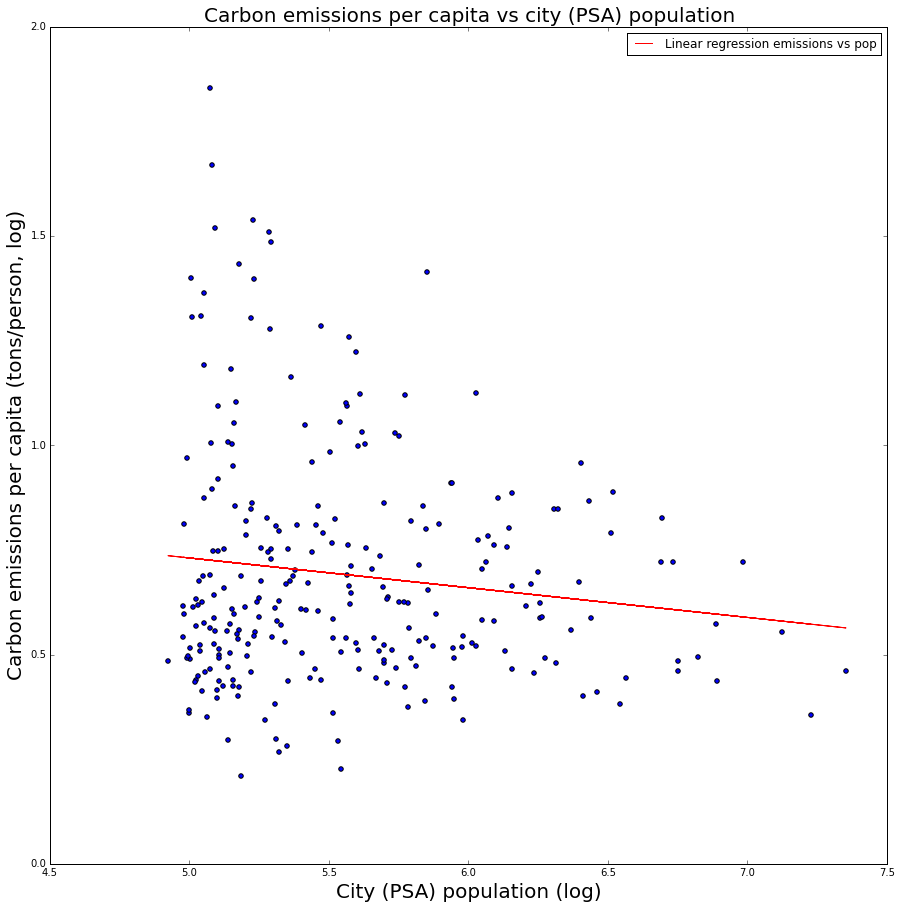

In [34]:
fig = pl.figure(figsize=(15,15))
xy_cut4.plot(kind = 'scatter', x = 'xlog', y = 'ylog', figsize = (15,15))
plot(xy_cut4.xlog, fit14.predict(), 'r', label="Linear regression emissions vs pop")
#plot(xy_cut4.xlog, curve4.predict(), 'ro', label="2 degree")
pl.title("Carbon emissions per capita vs city (PSA) population", fontsize = 20)
pl.xlabel("City (PSA) population (log)", fontsize=20)
pl.ylabel("Carbon emissions per capita (tons/person, log)", fontsize=20)
pl.legend()

#PSA POP Pearson

In [35]:
# conducting Pearson's test
pearson4 = scipy.stats.pearsonr(xy_cut4.xlog, xy_cut4.ylog)
pearson_alpha = 0.05

r,p = pearson4
def pearson_results4(r,p,a):
    print("The Pearson r coefficient is {}. Is the 2-tailed p-value of {} smaller than {}?".format(r,p,a))
    if p<a:
        print ("Yes.")
    else:
        print ("Nope.")
    
    print ('The correlation is {} at the {} alpha level.'.format(('significant' if p<a  else 'not significant'),a)) 

pearson_results4(r,p,pearson_alpha)

The Pearson r coefficient is -0.127446903282. Is the 2-tailed p-value of 0.036002332743 smaller than 0.05?
Yes.
The correlation is significant at the 0.05 alpha level.


In [36]:
print len(xy_cut), len(xy_cut2), len(xy_cut3), len(xy_cut4)

379 271 379 271


In [37]:
pearsontest = scipy.stats.pearsonr(xy_cut2.xlog, xy_cut4.xlog)
pearson_alpha = 0.05

r,p = pearsontest
def pearson_results5(r,p,a):
    print("The Pearson r coefficient is {}. Is the 2-tailed p-value of {} smaller than {}?".format(r,p,a))
    if p<a:
        print ("Yes.")
    else:
        print ("Nope.")
    
    print ('The correlation is {} at the {} alpha level.'.format(('significant' if p<a  else 'not significant'),a)) 

pearson_results5(r,p,pearson_alpha)

The Pearson r coefficient is 0.700770240759. Is the 2-tailed p-value of 2.42059610934e-41 smaller than 0.05?
Yes.
The correlation is significant at the 0.05 alpha level.


#SPEARMAN

In [38]:
# we'll use the same randomly-generated sample for consistency
spearman1 = scipy.stats.spearmanr(xy_cut2.xlog, xy_cut4.xlog)
print (spearman1)
spearman_alpha = 0.05
sr,sp = spearman1
def spearman_results(r,p,a):
    print("The Spearman r coefficient is {}. Is the 2-tailed p-value of {} smaller than {}?".format(r,p,a))
    if p<a:
        print ("Yes.")
    else:
        print ("Nope.")
    
    print ('The correlation is {} at the {} alpha level.'.format(('significant' if p<a  else 'not significant'),a)) 

spearman_results(sr,sp,spearman_alpha)

(0.6781672816728167, 7.4141850228959151e-38)
The Spearman r coefficient is 0.678167281673. Is the 2-tailed p-value of 7.4141850229e-38 smaller than 0.05?
Yes.
The correlation is significant at the 0.05 alpha level.


In [87]:
csa_pc.sort(ascending=False)

In [92]:
vara = csa_pc.to_frame()
varb = csa_p.to_frame()
csa_merged = pd.concat([vara, varb], axis=1)
csa_merged = csa_merged.rename(columns = {0: 'percapita', 1: 'population'})
csa_merged.to_csv('city_co2_ranking.csv')

# Central vs Outlying

In [52]:
# county density
df_master['county_d'] = df_master['county_pop2002']*1.0/df_master['county_land_area_sqmi']

# county per capita
df_master['co2_pc'] = df_master['tot_co2']*1.0/df_master['county_pop2002']

# county per capita electric
df_master['county_elec_pc'] = df_master['Electricity Prod']*1.0/df_master['county_pop2002']

# county per capita road
df_master['onroad_pc'] = df_master['Onroad']*1.0/df_master['county_pop2002']

In [54]:
df_master['onroad_pc'].describe()

count    1196.000000
mean        1.752524
std         1.129623
min         0.238851
25%         1.250600
50%         1.532195
75%         1.940597
max        23.413443
Name: onroad_pc, dtype: float64

In [55]:
# county density
dfc['county_d'] = dfc['county_pop2002']*1.0/dfc['county_land_area_sqmi']

# county per capita
dfc['co2_pc'] = dfc['tot_co2']*1.0/dfc['county_pop2002']

# county per capita electric
dfc['county_elec_pc'] = dfc['Electricity Prod']*1.0/dfc['county_pop2002']

# county per capita road
dfc['onroad_pc'] = dfc['Onroad']*1.0/dfc['county_pop2002']

/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [59]:
dfc.onroad_pc.describe()

count    744.000000
mean       1.480112
std        0.479576
min        0.238851
25%        1.175737
50%        1.402054
75%        1.700492
max        3.878719
Name: onroad_pc, dtype: float64

In [60]:
# county density
dfo['county_d'] = dfo['county_pop2002']*1.0/dfo['county_land_area_sqmi']

# county per capita
dfo['co2_pc'] = dfo['tot_co2']*1.0/dfo['county_pop2002']

# county per capita electric
dfo['county_elec_pc'] = dfo['Electricity Prod']*1.0/dfo['county_pop2002']

# county per capita road
dfo['onroad_pc'] = dfo['Onroad']*1.0/dfo['county_pop2002']

/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Daynan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [64]:
dfo.onroad_pc.describe()

count    452.000000
mean       2.200919
std        1.636544
min        0.541775
25%        1.477171
50%        1.848960
75%        2.408000
max       23.413443
Name: onroad_pc, dtype: float64

# KS 2-sample test of variance for Central vs Outlying

In [69]:
scipy.stats.ks_2samp(dfc.onroad_pc, dfo.onroad_pc)

(0.36442573032638687, 2.3695938752214343e-33)

In [70]:
scipy.stats.ks_2samp(dfc.co2_pc, dfo.co2_pc)

(0.077267104386716134, 0.066196200456997367)